In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need, create_hourly_residential_demand_profile, heating_hourly_profile
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

# Preprocessing

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

In [5]:
L = [1850,1750,1800,1850,1900,1950,2050,2120,2250,2100,2000,1850,1700,1550,1600,1650,1800,2000,2100,2150,2200,2150,2100,2000]
[e/sum(L) for e in L]

[0.03981063051431031,
 0.0376587045405638,
 0.03873466752743705,
 0.03981063051431031,
 0.04088659350118356,
 0.04196255648805681,
 0.044114482461803314,
 0.04562083064342587,
 0.04841833440929632,
 0.045190445448676564,
 0.043038519474930065,
 0.03981063051431031,
 0.036582741553690554,
 0.0333548525930708,
 0.03443081557994405,
 0.035506778566817304,
 0.03873466752743705,
 0.043038519474930065,
 0.045190445448676564,
 0.04626640843554982,
 0.04734237142242307,
 0.04626640843554982,
 0.045190445448676564,
 0.043038519474930065]

In [39]:
L = [2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 3, 3]
[e/sum(L) for e in L]

[0.044444444444444446,
 0.044444444444444446,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.044444444444444446,
 0.044444444444444446,
 0.06666666666666667,
 0.044444444444444446,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.022222222222222223,
 0.044444444444444446,
 0.044444444444444446,
 0.06666666666666667,
 0.08888888888888889,
 0.08888888888888889,
 0.06666666666666667,
 0.06666666666666667]

## Costs and heating need

2022-12-06 16:11:15,610 - 82509 - log_ - INFO - Creating AgentBuildings object
2022-12-06 16:11:15,610 - 82509 - log_ - INFO - Creating AgentBuildings object
2022-12-06 16:11:15,610 - 82509 - log_ - INFO - Creating AgentBuildings object
2022-12-06 16:11:15,610 - 82509 - log_ - INFO - Creating AgentBuildings object
2022-12-06 16:11:15,610 - 82509 - log_ - INFO - Creating AgentBuildings object


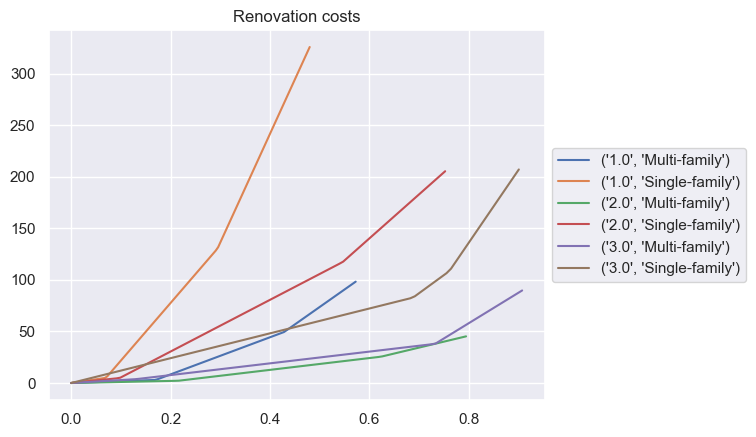

In [132]:
hourly_profile_test = heating_hourly_profile(method="valentin", percentage=0)

# TODO: attention au choix de hourly profile !!
# ['Occupancy status', 'Income owner', 'Income tenant', 'Housing type', 'Heating system']
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', "Housing type"], climate=2006, smooth=False, building_stock="medium_3",
                                      hourly_profile=hourly_profile_test)
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True, plot_tot=True)

threshold_linearized_renovation_costs[threshold_linearized_renovation_costs < 0] = 0  # handles cases where the linearization was not perfect

In [4]:
sum([(dict_heat[key]*1).sum() for key in dict_heat.keys()])

192018.42898243916

2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object
2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object


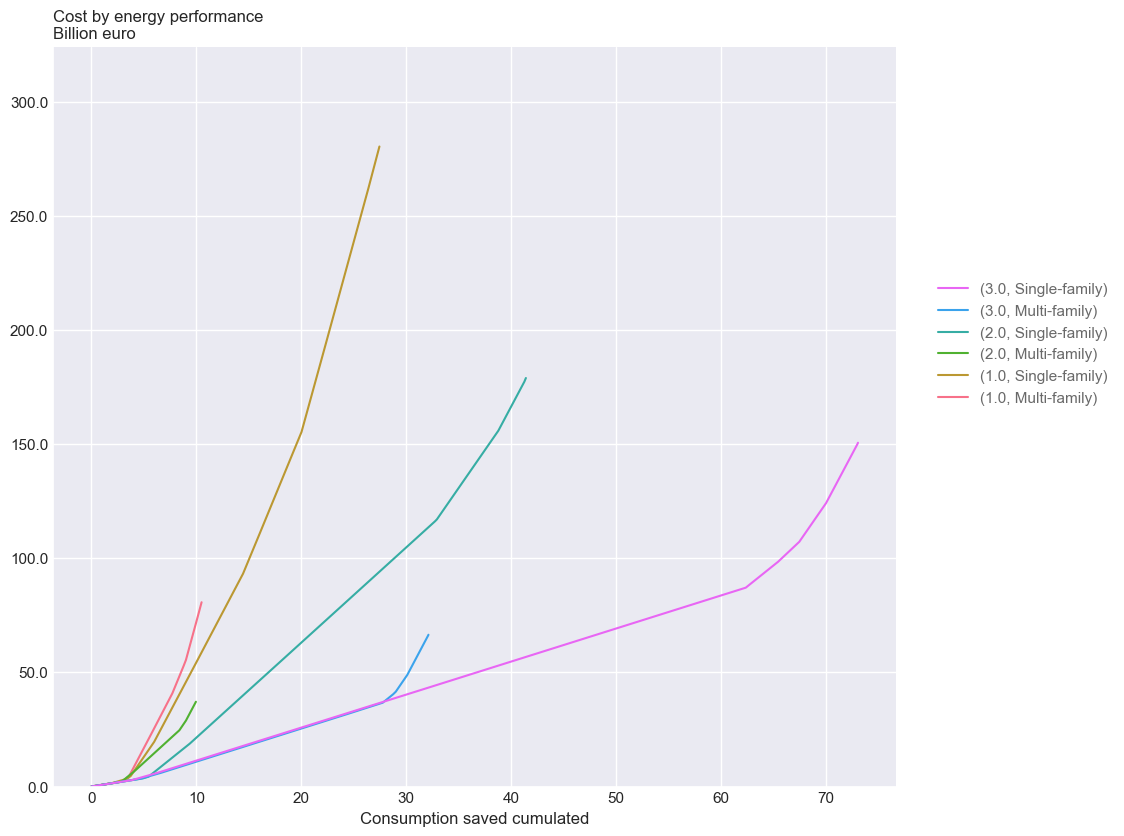

In [5]:
from project.utils import make_plots
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3", percent=False)
make_plots(dict_cost, 'Cost by energy performance (Billion euro)', loc="left", left=1.15)

## Process generation output

In [44]:
tmp = m_scc.hourly_generation
climate = 2006
tmp["date"] = tmp.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
tmp = tmp.set_index("date")

In [49]:
h_start, h_end = 0, 60 # winter
# h_start, h_end = 2800, 3000 # spring
# h_start, h_end = 4300, 4500 # summer
# list_hour = tmp.index[h_start:h_end].to_list()
date_start, date_end = datetime.datetime(climate, 2, 1, 0), datetime.datetime(climate, 2, 15, 23)
list_time = tmp.index[(tmp.index > date_start) & (tmp.index < date_end)].to_list()

prod_label = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification",
              "ocgt", "ccgt", "methanation", "electrolysis", "battery1", "battery4", "hydrogen", "methane", "phs"]
prod_label = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "nuclear", "methanization", "pyrogazification", "ocgt", "ccgt"]
prod_label = ["offshore_f", "offshore_g", "onshore", "nuclear", "methanization", "pyrogazification", "ocgt", "ccgt", "methanation"]
# list_prod = [tmp[key].iloc[h_start:h_end].to_list() for key in prod_label]
list_prod = [tmp[key][list_time].to_list() for key in prod_label]

str_label = ["hydrogen", "methane", "hydrogen_in", "methane_in", "electrolysis"]
list_str = [tmp[key][list_time].to_list() for key in str_label]


methane_label = ["methane", "methane_in"]
list_methane = [tmp[key][list_time].to_list() for key in methane_label]

gas_label = ["methane", "methane_in", "methanization", "pyrogazification"]
list_gas = [tmp[key][list_time].to_list() for key in gas_label]

single_tec_label = ["electrolysis"]
list_single_tec = [tmp[key][list_time].to_list() for key in single_tec_label]



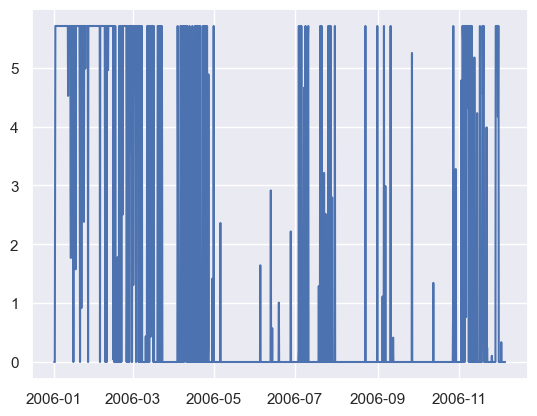

In [41]:
plt.plot(list_time[1:-1:5], list_str[0][1:-1:5])

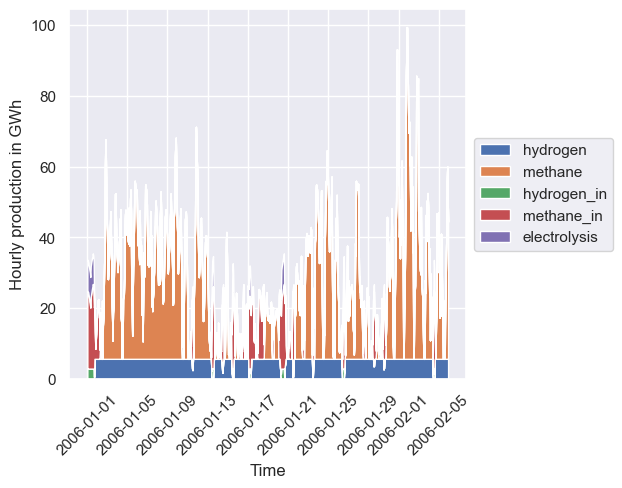

In [46]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_str, labels=str_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# ax.set_ylim(0,10)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

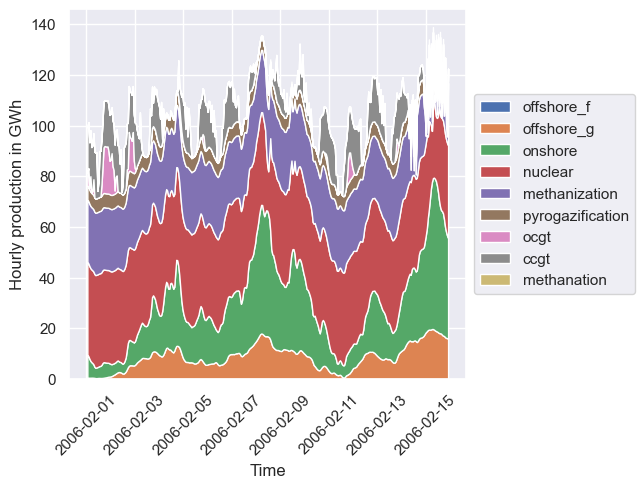

In [50]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_prod, labels=prod_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [13]:
list_methane[1]

[19.504193852530864,
 19.310528146210512,
 16.982929174480464,
 14.074685041457915,
 11.166440908435423,
 5.930597803680282,
 2.3622818239011742,
 0.0,
 4.957837541627761,
 10.00013225928534,
 17.176477561575464,
 20.49330699764909,
 21.07395215893909,
 21.145978703969938,
 19.270497774879285,
 18.087718923440704,
 8.583774649418036,
 1.0563962108442517,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.102829904838295,
 8.279878177996544,
 10.18077027991935,
 8.102425901397009,
 6.378216450793781,
 2.291691388141949,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.506035585056485,
 4.575407969507653,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.871290454944525,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

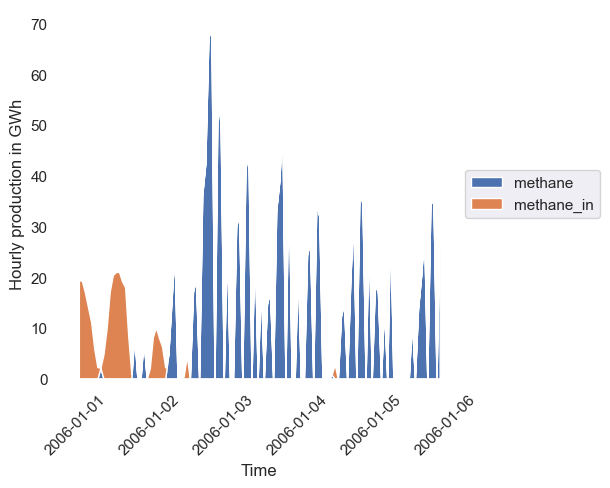

In [11]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_methane, labels=methane_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

In [369]:
list_single_tec

[[9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  9.25483135879164,
  4.697509106381841,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [34]:
tmp[["hydrogen", "hydrogen_in", "hydrogen_charge", "electrolysis"]]

,hydrogen,hydrogen_in,hydrogen_charge,electrolysis
date,,,,
2006-01-01 00:00:00,0.0,3.472742,7321.801839,9.180505
2006-01-01 01:00:00,0.0,3.472742,7325.274581,9.180505
2006-01-01 02:00:00,0.0,3.472742,7328.747323,9.180505
2006-01-01 03:00:00,0.0,3.472742,7332.220065,9.180505
2006-01-01 04:00:00,0.0,3.472742,7335.692807,9.180505
...,...,...,...,...
2006-12-31 19:00:00,0.0,3.472742,7304.438129,9.180505
2006-12-31 20:00:00,0.0,3.472742,7307.910871,9.180505
2006-12-31 21:00:00,0.0,3.472742,7311.383613,9.180505


In [20]:
tmp[["heat_demand", "CH4_demand", "elec_demand", "methane", "methane_in", "methane_charge", "methanization", "pyrogazification", "methanation"]]

,heat_demand,CH4_demand,elec_demand,methane,methane_in,methane_charge,methanization,pyrogazification,methanation
date,,,,,,,,,
2006-01-01 00:00:00,49.101582,14.129032,69.712739,0.0,31.053853,14101.202260,34.209394,7.990868,2.982624
2006-01-01 01:00:00,54.713191,15.058065,65.166886,0.0,30.124820,14132.256113,34.209394,7.990868,2.982624
2006-01-01 02:00:00,57.518995,15.522581,59.364789,0.0,29.660304,14162.380933,34.209394,7.990868,2.982624
2006-01-01 03:00:00,58.921898,15.754839,56.803051,0.0,29.428046,14192.041238,34.209394,7.990868,2.982624
2006-01-01 04:00:00,64.533507,16.683871,53.313940,0.0,28.499014,14221.469284,34.209394,7.990868,2.982624
...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00,39.539773,14.729032,71.801487,0.0,30.453853,13945.100739,34.209394,7.990868,2.982624
2006-12-31 20:00:00,35.682234,13.877419,75.025726,0.0,31.305466,13975.554591,34.209394,7.990868,2.982624
2006-12-31 21:00:00,32.789080,13.238710,74.135638,0.0,31.944175,14006.860057,34.209394,7.990868,2.982624


In [30]:
tmp[["heat_demand", "CH4_demand", "elec_demand", "methane", "methane_in", "methane_charge", "methanization", "pyrogazification", "methanation"]]

,heat_demand,CH4_demand,elec_demand,methane,methane_in,methane_charge,methanization,pyrogazification,methanation
date,,,,,,,,,
2006-01-01 00:00:00,58.029142,0,69.712739,0.0,0.0,0.0,7.683871,3.305333,3.139829
2006-01-01 01:00:00,64.661044,1,65.166886,0.0,0.0,0.0,8.612903,3.305333,3.139829
2006-01-01 02:00:00,67.976995,2,59.364789,0.0,0.0,0.0,9.077419,3.305333,3.139829
2006-01-01 03:00:00,69.634970,3,56.803051,0.0,0.0,0.0,9.309677,3.305333,3.139829
2006-01-01 04:00:00,76.266872,4,53.313940,0.0,0.0,0.0,15.062244,3.305333,3.139829
...,...,...,...,...,...,...,...,...,...
2006-12-31 19:00:00,46.728823,8755,71.801487,0.0,0.0,0.0,8.283871,3.305333,3.139829
2006-12-31 20:00:00,42.169913,8756,75.025726,0.0,0.0,0.0,7.432258,3.305333,3.139829
2006-12-31 21:00:00,38.750731,8757,74.135638,0.0,0.0,0.0,6.793548,3.305333,3.139829


In [15]:
tmp[["elec_demand", "battery1", "battery4", "phs", "battery1_in", "battery4_in", "phs_in"]]

,elec_demand,battery1,battery4,phs,battery1_in,battery4_in,phs_in
date,,,,,,,
2006-01-01 00:00:00,69.712739,0.000000,6.839157,0.0,0.0,0.00000,0.000000
2006-01-01 01:00:00,65.166886,0.000000,6.160698,0.0,0.0,0.00000,0.000000
2006-01-01 02:00:00,59.364789,0.000000,2.664485,0.0,0.0,0.00000,0.000000
2006-01-01 03:00:00,56.803051,0.305741,1.314967,0.0,0.0,0.00000,0.000000
2006-01-01 04:00:00,53.313940,0.000000,0.305752,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...,...
2006-12-31 19:00:00,71.801487,0.000000,0.000000,0.0,0.0,0.00000,0.000000
2006-12-31 20:00:00,75.025726,0.000000,0.000000,0.0,0.0,0.00000,0.000000
2006-12-31 21:00:00,74.135638,0.000000,0.000000,0.0,0.0,0.00000,0.000000


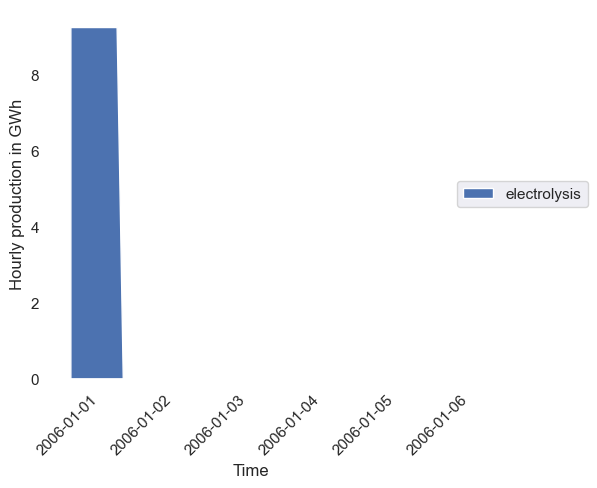

In [368]:
fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_time, list_single_tec, labels=single_tec_label)
ax.set_ylabel("Hourly production in GWh")
ax.set_xlabel("Time")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
plt.show()

# Run model

In [158]:
list_scc = [200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame()
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

dict_heat_modif = {key: dict_heat[key]*1.4 for key in dict_heat.keys()}  # TODO: a enlever, permet de voir l'impact d'augmenter le besoin en chaleur

# we add hourly heat profile
hourly_gas = create_hourly_residential_demand_profile(total_consumption=25*1e3, method="RTE")  # value for gas heating demand in tertiary sector
hourly_ECS = pd.Series(2.5, index=hourly_gas.index)  # may include industry as well (if just tertiary + residential ECS, we get a total of 22TWh per year, or 2.5GWh per hour)
hourly_CH4_gas = hourly_gas + hourly_ECS

scenario_cost_high = {
    "capex": {
        "heat_pump": 1050,  # change back to actual level of price
        "gas_boiler": 300,  # hypothesis Zeyen
        "resistive": 100,
        "offshore_f": 3600,
        "offshore_g": 2300,
        "nuclear": 5500
    } ,
    "fOM": {
        "gas_boiler": 21  # hypothesis Zeyen
    } ,
    "vOM": {
        "heat_pump": 0.002  # hypothesis Zeyen
    },
    "conversion_efficiency": {
        "gas_boiler": 0.75
    },
    "miscellaneous": {
        "max_methanization": 50,
        "max_pyrogazification": 50,
        "CH4_demand": 1.5,
        "lifetime_renov": 40
    },
    "maximum_capacity": {
        "nuclear": 30,
        "offshore_f": 20,
        "offshore_g": 40,
        "phs": 8
    },
    "fix_capa": {
        "h2_ccgt": 0,
        # "nuclear": 0
        # "methane": 0,  # we test when we do not allow for hydrogen/methane storage
        # "hydrogen": 0,
        # "battery1": 0,
        # "battery4": 0,
        # "methanation": 4,
        # "pyrogazification": 0,
        # "methanization": 0
    }
}  # we increase prices to check the impact on the output

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat_modif, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050, scenario_cost=scenario_cost_high, hp_hourly=True, renov=None,
                       hourly_heat_gas=hourly_CH4_gas)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().transpose()], axis=0, ignore_index=True)

Social cost of carbon: 200


2022-12-06 16:45:39,016 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-06 16:46:30,831 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:281: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:296: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 300


2022-12-06 16:46:46,254 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-06 16:47:17,485 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:281: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:296: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 400


2022-12-06 16:47:32,933 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-06 16:48:08,949 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:281: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:296: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 500


2022-12-06 16:48:24,439 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-12-06 16:49:00,504 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:281: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:296: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


# Post-processing

## Model output

In [159]:
m_scc.objective

62.31194011408579

In [128]:
H2_spot_price = [1e6 * m_scc.model.dual[m_scc.model.methane_balance_constraint[h]] for h in m_scc.model.h]

In [130]:
np.std(H2_spot_price)

7.8422711620413486

In [131]:
m_scc.lcoe_per_tec

{'offshore_f': 56.542210329277765,
 'offshore_g': 37.42157167119335,
 'onshore': 34.275185368784854,
 'pv_g': 26.682669110769986,
 'pv_c': nan,
 'river': 43.50947140653866,
 'lake': 54.00642398372373,
 'nuclear': 92.92547360996893,
 'ocgt': 1024.921131046005,
 'ccgt': 356.79492664156174,
 'h2_ccgt': nan,
 'methanization': 61.211903432858904,
 'pyrogazification': 81.59902891358317}

In [33]:
m_scc.storage_annuities

0
battery1    24.278262
battery4    14.281330
phs          1.194211
hydrogen     0.069679
methane      0.061392
Name: 1, dtype: float64

In [160]:
m_scc.capacities

offshore_f            0.000000
offshore_g           40.000000
onshore              80.000000
pv_g                 86.019216
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization        26.341323
ocgt                 27.258760
ccgt                 21.978825
nuclear              25.540912
h2_ccgt               0.000000
phs                   8.000000
battery1              0.155444
battery4              5.734373
methanation           2.090312
pyrogazification      5.707763
electrolysis          9.286817
natural_gas           0.000000
hydrogen              5.707763
methane             121.259283
heat_pump            43.686492
gas_boiler           28.153207
resistive            11.699235
fuel_boiler           0.000000
wood_boiler           0.595798
dtype: float64

In [161]:
m_scc.energy_capacity

phs           135.500000
battery1        0.155444
battery4       22.937492
hydrogen     9034.602800
methane     24100.137100
dtype: float64

In [162]:
m_scc.generation_per_technology

{'offshore_f': 0.0,
 'offshore_g': 184.1058628575212,
 'onshore': 227.55635575911973,
 'pv_g': 122.31898747033425,
 'pv_c': 0.0,
 'river': 28.48260030787517,
 'lake': 15.30218636999974,
 'methanization': 49.999999999998046,
 'ocgt': 1.8749592752623119,
 'ccgt': 19.72011220329106,
 'nuclear': 150.20542672851983,
 'h2_ccgt': 0.0,
 'phs': 18.068650767168535,
 'battery1': 0.06517946327154417,
 'battery4': 7.620541365364083,
 'methanation': 12.90000000000117,
 'pyrogazification': 49.99999999999335,
 'electrolysis': 49.99999999999888,
 'natural_gas': 0.0,
 'hydrogen': 17.233978732524488,
 'methane': 33.87582847031751,
 'heat_pump': 147.68729371002075,
 'gas_boiler': 20.036935301924302,
 'resistive': 8.631818277310828,
 'fuel_boiler': 0.0,
 'wood_boiler': 0.0005957975864954873}

In [9]:
sns.set_theme()

## Graphs

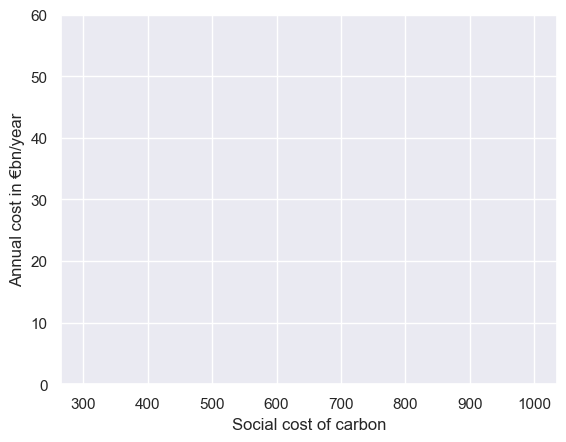

In [75]:
plt.plot(list_scc, list_social_cost)
plt.ylim(0, 60)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

In [8]:
m_scc.summary

weighted_price_demand           70.864314
weighted_price_generation       66.541615
elec_demand_tot                561.970000
hydrogen_demand_tot              0.050000
methane_demand_tot              70.560000
heat_demand_tot                192.018429
offshore_f                       0.000000
offshore_g                      92.052931
onshore                        227.556356
pv_g                           120.643922
pv_c                             0.000000
river                           28.482600
lake                            15.302186
methanization                   30.000000
ocgt                             1.392751
ccgt                             1.761506
nuclear                        208.820529
h2_ccgt                         29.758709
phs                             15.765215
battery1                         0.396137
battery4                         2.346426
methanation                      7.740000
pyrogazification                70.000000
electrolysis                    52

In [84]:
m_scc.renovation_annuities

('1.0', 'Multi-family')_0      1129.744108
('1.0', 'Multi-family')_1     11542.032942
('1.0', 'Multi-family')_2     21752.927287
('1.0', 'Single-family')_0     4626.310345
('1.0', 'Single-family')_1    35844.705111
('1.0', 'Single-family')_2    67594.867759
('2.0', 'Multi-family')_0       649.148304
('2.0', 'Multi-family')_1      3671.466194
('2.0', 'Multi-family')_2      7394.222058
('2.0', 'Single-family')_0     3170.377618
('2.0', 'Single-family')_1    16080.486068
('2.0', 'Single-family')_2    27401.766180
('3.0', 'Multi-family')_0      1844.341166
('3.0', 'Multi-family')_1      3650.836372
('3.0', 'Multi-family')_2     18963.450576
('3.0', 'Single-family')_0     7725.974510
('3.0', 'Single-family')_1    22551.249466
('3.0', 'Single-family')_2    45239.792004
dtype: float64

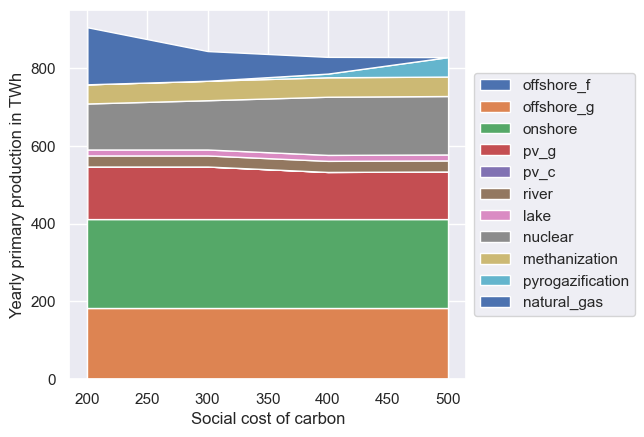

In [163]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

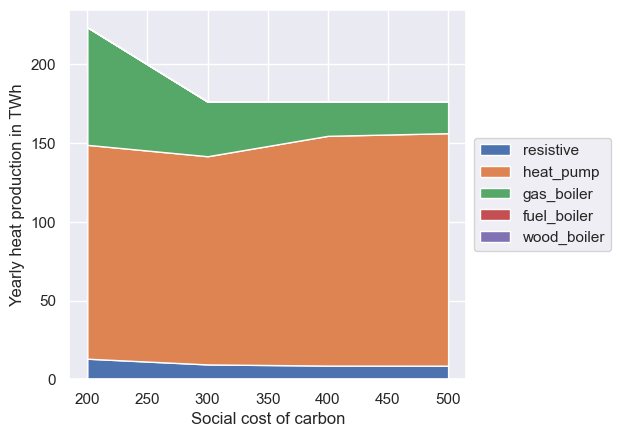

In [164]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [78]:
renovation_rate_df

1.0                        2.0                        3.0  \
  Multi-family Single-family Multi-family Single-family Multi-family   
0     0.000000      0.000000     0.000000      0.000000     0.000000   
1     0.170003      0.000000     0.215394      0.000000     0.131225   
2     0.170003      0.000000     0.215394      0.097347     0.131225   
3     0.170003      0.070006     0.215394      0.097347     0.131225   
4     0.170003      0.070006     0.215394      0.097347     0.131225   
5     0.170003      0.070006     0.215394      0.097347     0.131225   

                 
  Single-family  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0

## Renovation

In [140]:
renovation_rate_df_plot = renovation_rate_df.copy()
renovation_rate_df_plot.index = list_scc
renovation_rate_df_plot = renovation_rate_df_plot.stack(level=[i for i in range(renovation_rate_df_plot.columns.nlevels)]).reset_index()
renovation_rate_df_plot

,level_0,level_1,level_2,0
0,200,1.0,Multi-family,0.169996
1,200,1.0,Single-family,0.070005
2,200,2.0,Multi-family,0.215400
3,200,2.0,Single-family,0.097350
4,200,3.0,Multi-family,0.732041
5,200,3.0,Single-family,0.000000
6,300,1.0,Multi-family,0.169996
7,300,1.0,Single-family,0.070005
8,300,2.0,Multi-family,0.215400
9,300,2.0,Single-family,0.097350


In [141]:
renovation_rate_df_plot = renovation_rate_df.copy()
renovation_rate_df_plot.index = list_scc
renovation_rate_df_plot = renovation_rate_df_plot.stack(level=[i for i in range(renovation_rate_df_plot.columns.nlevels)]).reset_index()
renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"]+ ' ' + row["level_2"], axis=1)
# renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"]+ ' ' + row["level_2"]+ ' ' + row["level_3"], axis=1)
# renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"], axis=1)
renovation_rate_df_plot = renovation_rate_df_plot.rename(columns={"level_0": "scc", 0: "renovation_rate"})

In [142]:
renovation_rate_df_plot

,scc,level_1,level_2,renovation_rate,archetype
0,200,1.0,Multi-family,0.169996,1.0 Multi-family
1,200,1.0,Single-family,0.070005,1.0 Single-family
2,200,2.0,Multi-family,0.215400,2.0 Multi-family
3,200,2.0,Single-family,0.097350,2.0 Single-family
4,200,3.0,Multi-family,0.732041,3.0 Multi-family
5,200,3.0,Single-family,0.000000,3.0 Single-family
6,300,1.0,Multi-family,0.169996,1.0 Multi-family
7,300,1.0,Single-family,0.070005,1.0 Single-family
8,300,2.0,Multi-family,0.215400,2.0 Multi-family
9,300,2.0,Single-family,0.097350,2.0 Single-family


In [143]:
df_heat = pd.DataFrame(dict_heat_modif).stack(
    level=[i for i in range(pd.DataFrame(dict_heat_modif).columns.nlevels)]).reset_index()
df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"] + ' ' + row["level_2"]+ ' ' + row["level_3"], axis=1)
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat = df_heat.rename(columns={"level_0": "date", 0: "heat_demand"})

df_heat

,date,level_1,level_2,heat_demand,archetype
0,0,1.0,Multi-family,6.876903,1.0 Multi-family
1,0,1.0,Single-family,17.977764,1.0 Single-family
2,0,2.0,Multi-family,4.000752,2.0 Multi-family
3,0,2.0,Single-family,14.841606,2.0 Single-family
4,0,3.0,Multi-family,9.879276,3.0 Multi-family
...,...,...,...,...,...
52555,8759,1.0,Single-family,13.078001,1.0 Single-family
52556,8759,2.0,Multi-family,2.945287,2.0 Multi-family
52557,8759,2.0,Single-family,11.132699,2.0 Single-family
52558,8759,3.0,Multi-family,7.429185,3.0 Multi-family


In [144]:
renovation_rate_df_plot

,scc,level_1,level_2,renovation_rate,archetype
0,200,1.0,Multi-family,0.169996,1.0 Multi-family
1,200,1.0,Single-family,0.070005,1.0 Single-family
2,200,2.0,Multi-family,0.215400,2.0 Multi-family
3,200,2.0,Single-family,0.097350,2.0 Single-family
4,200,3.0,Multi-family,0.732041,3.0 Multi-family
5,200,3.0,Single-family,0.000000,3.0 Single-family
6,300,1.0,Multi-family,0.169996,1.0 Multi-family
7,300,1.0,Single-family,0.070005,1.0 Single-family
8,300,2.0,Multi-family,0.215400,2.0 Multi-family
9,300,2.0,Single-family,0.097350,2.0 Single-family


In [145]:
heat_and_renov = pd.merge(renovation_rate_df_plot.groupby(["archetype", "scc"])["renovation_rate"].sum().reset_index(), df_heat.groupby("archetype")["heat_demand"].sum().reset_index(),
         on='archetype')
heat_and_renov

,archetype,scc,renovation_rate,heat_demand
0,1.0 Multi-family,200,0.169996,24348.242364
1,1.0 Multi-family,300,0.169996,24348.242364
2,1.0 Multi-family,400,0.169996,24348.242364
3,1.0 Multi-family,500,0.169996,24348.242364
4,1.0 Single-family,200,0.070005,66197.516441
5,1.0 Single-family,300,0.070005,66197.516441
6,1.0 Single-family,400,0.070005,66197.516441
7,1.0 Single-family,500,0.070005,66197.516441
8,2.0 Multi-family,200,0.215400,14870.492739
9,2.0 Multi-family,300,0.215400,14870.492739


In [146]:
heat = {}
for n, g in heat_and_renov.groupby('scc'):
    heat.update({n: g["heat_demand"].sum()})
heat

{200: 268825.8005754148,
 300: 268825.8005754148,
 400: 268825.8005754148,
 500: 268825.8005754148}

In [147]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

In [148]:
renov

{200: 0.16813482060183346,
 300: 0.34397459864448343,
 400: 0.34397459864448343,
 500: 0.34397459864448343}

In [149]:
renovation_rate_df_plot.sort_values(by="renovation_rate", ascending=False)

,scc,level_1,level_2,renovation_rate,archetype
22,500,3.0,Multi-family,0.732041,3.0 Multi-family
4,200,3.0,Multi-family,0.732041,3.0 Multi-family
16,400,3.0,Multi-family,0.732041,3.0 Multi-family
10,300,3.0,Multi-family,0.732041,3.0 Multi-family
23,500,3.0,Single-family,0.687660,3.0 Single-family
17,400,3.0,Single-family,0.687660,3.0 Single-family
11,300,3.0,Single-family,0.687660,3.0 Single-family
14,400,2.0,Multi-family,0.215400,2.0 Multi-family
2,200,2.0,Multi-family,0.215400,2.0 Multi-family
20,500,2.0,Multi-family,0.215400,2.0 Multi-family


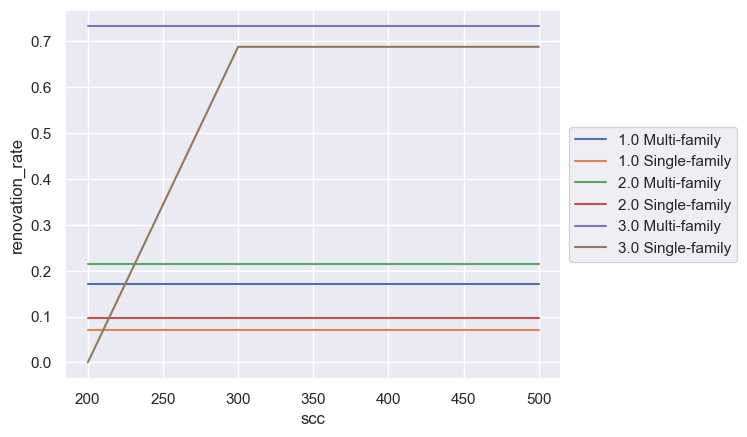

In [150]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

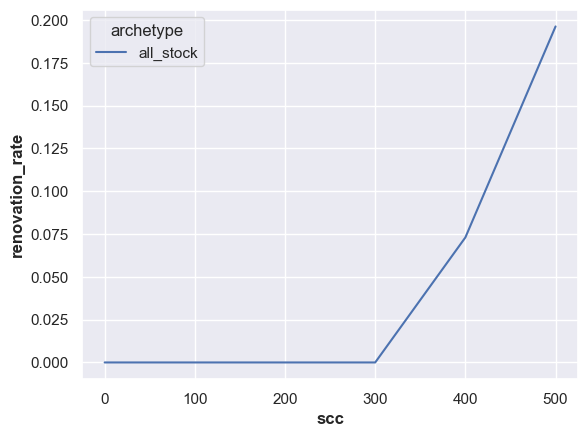

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")

## Process weather data

### Process weather data

In [117]:
from pathlib import Path
from eoles.utils import get_pandas
path_weather = Path("eoles") / "inputs" / "ninja_weather_country_FR_merra-2_population_weighted.csv"
weather = get_pandas(path_weather,
           lambda x: pd.read_csv(x, header=2))
weather["date"] = weather.apply(lambda row: datetime.datetime.strptime(row["time"], '%Y-%m-%d %H:%M:%S'), axis=1)
weather = weather.loc[(weather.date >= datetime.datetime(climate, 1, 1, 0)) & (weather.date <= datetime.datetime(climate, 12, 31, 23))]
weather["day"] = weather.apply(lambda row: row["date"].date(), axis=1)

weather_daily = weather.groupby("day")["temperature"].mean().reset_index().rename(columns={"temperature": "daily_temperature"})

weather = pd.merge(weather, weather_daily, on=["day"])

load_factors = m_scc.load_factors.reset_index().rename(columns={0: "technology", 1: "hour", 2: "capacity_factor"})
load_factors["date"] = load_factors.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)

weather = pd.merge(weather, load_factors.drop(columns=["hour"]), on=["date"])

In [96]:
weather

,time,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,date,day,daily_temperature,technology,capacity_factor
0,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,offshore_f,0.936250
1,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,offshore_g,0.865143
2,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,onshore,0.511702
3,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,pv_g,0.000000
4,2006-01-01 00:00:00,0.240,3.083,0.0,0.0,0.0288,2.5060,0.8610,1.2265,2006-01-01 00:00:00,2006-01-01,3.870000,pv_c,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,offshore_g,0.988143
52556,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,onshore,0.818481
52557,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,pv_g,0.000000
52558,2006-12-31 23:00:00,0.574,10.358,0.0,0.0,0.0000,0.0345,0.9614,1.2175,2006-12-31 23:00:00,2006-12-31,8.016542,pv_c,0.000000


In [118]:
# Plot evolution of heating need and temperature
climate = 2006
df_heat_plot = df_heat.rename(columns={"date": "hour"})  # we use previously defined df_heat
df_heat_plot["date"] = df_heat_plot.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
df_heat_plot = df_heat_plot.groupby("date")["heat_demand"].sum().reset_index()

date_start, date_end = datetime.datetime(climate, 1, 16, 0), datetime.datetime(climate, 2, 28, 23)
# list_time = df_heat_plot.index[(df_heat_plot.index > date_start) & (df_heat_plot.index < date_end)].to_list()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


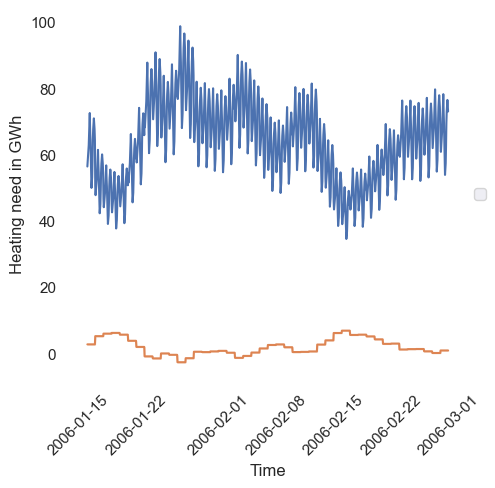

In [119]:
fig = plt.figure()
ax = plt.subplot(111)
# sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand", hue="archetype")
sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand")  # plot heating need
sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end)], x="date", y="daily_temperature")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
ax.set_ylabel("Heating need in GWh")
ax.set_xlabel("Time")

# ax2 = ax.twinx()  # add other axis for weather data
# sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end) & (weather.technology.isin(["offshore_f", "onshore"]))], x="date", y="capacity_factor",
#              hue="technology", ax=ax2)

# ax.set_ylim(0,10)
# Shrink current axis by 20%

plt.show()

### Smooth heating profile

In [120]:
dict_cost_smooth, dict_heat_smooth = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=True, building_stock="medium_3",
                                      hourly_profile=hourly_profile_test)
dict_heat_smooth = process_heating_need(dict_heat_smooth, climate=2006)
dict_heat_modif_smooth = {key: dict_heat_smooth[key]*1.1 for key in dict_heat_smooth.keys()}  # TODO: a enlever, permet de voir l'impact d'augmenter le besoin en chaleur

df_heat_smooth = pd.DataFrame(dict_heat_modif_smooth).stack(
    level=[i for i in range(pd.DataFrame(dict_heat_modif_smooth).columns.nlevels)]).reset_index()
df_heat_smooth["archetype"] = df_heat_smooth.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat_smooth = df_heat_smooth.rename(columns={"level_0": "date", 0: "heat_demand"})

# Plot evolution of heating need and temperature

climate = 2006
df_heat_smooth = df_heat_smooth.rename(columns={"date": "hour"})
df_heat_smooth["date"] = df_heat_smooth.apply(lambda row: datetime.datetime(climate, 1, 1, 0) + datetime.timedelta(hours=row["hour"]), axis=1)
df_heat_smooth = df_heat_smooth.groupby("date")["heat_demand"].sum().reset_index()


2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object
2022-12-05 14:22:58,256 - 75961 - log_ - INFO - Creating AgentBuildings object


In [124]:
df_heat_plot.sum()

/var/folders/1c/f0py8khj3bx759_g1q03n6fc0000gn/T/ipykernel_75961/3837886878.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_heat_plot.sum()


heat_demand    211220.271881
dtype: float64

In [123]:
df_heat_smooth.sum()

/var/folders/1c/f0py8khj3bx759_g1q03n6fc0000gn/T/ipykernel_75961/4253487980.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_heat_smooth.sum()


heat_demand    210788.270868
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


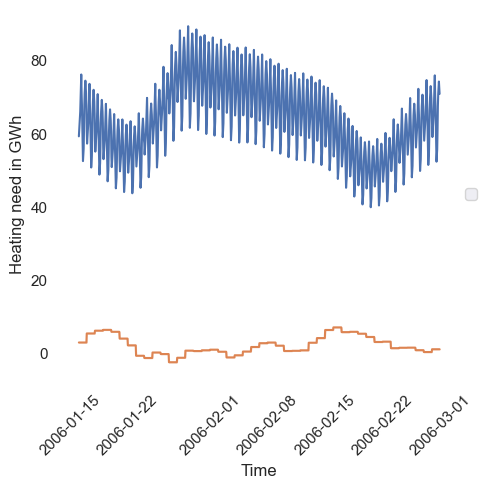

In [121]:
date_start, date_end = datetime.datetime(climate, 1, 16, 0), datetime.datetime(climate, 2, 28, 23)
# list_time = df_heat_plot.index[(df_heat_plot.index > date_start) & (df_heat_plot.index < date_end)].to_list()

fig = plt.figure()
ax = plt.subplot(111)
# sns.lineplot(df_heat_plot.loc[(df_heat_plot.date > date_start) & (df_heat_plot.date < date_end)], x="date", y="heat_demand", hue="archetype")
sns.lineplot(df_heat_smooth.loc[(df_heat_smooth.date > date_start) & (df_heat_smooth.date < date_end)], x="date", y="heat_demand")  # plot heating need
sns.lineplot(weather.loc[(weather.date > date_start) & (weather.date < date_end)], x="date", y="daily_temperature")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_facecolor('xkcd:white')
plt.xticks(rotation = 45)
ax.set_ylabel("Heating need in GWh")
ax.set_xlabel("Time")

plt.show()